   holiday  weekday  summertime      temp       dew  humidity    precip  snow  \
0        0        0   -1.344254 -2.419627 -2.269781 -0.537283 -0.209118   0.0   
1        0        1   -1.344254 -1.782607 -2.050293 -1.203654 -0.209118   0.0   
2        0        1    0.743907  1.262128  1.401656  0.496090 -0.209118   0.0   
3        0        0   -1.344254 -1.307542 -1.172340 -0.219564 -0.209118   0.0   
4        0        1   -1.344254 -0.379006 -1.910618 -2.370721 -0.209118   0.0   

   snowdepth  windspeed  cloudcover  visibility  month_sin  month_cos  \
0  -0.124683   0.414935   -0.999503    0.242212   0.678434   1.227255   
1  -0.124683   1.395045    0.652979    0.242212   0.678434   1.227255   
2  -0.124683  -1.687144    0.512472    0.242212  -1.259495  -0.699517   
3  -0.124683   0.788924   -1.964724    0.242212   0.678434   1.227255   
4  -0.124683  -0.333044   -0.602419    0.242212   1.387764   0.005730   

   day_of_week_sin  day_of_week_cos  hour_of_day_sin  hour_of_day_cos  
0 

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(


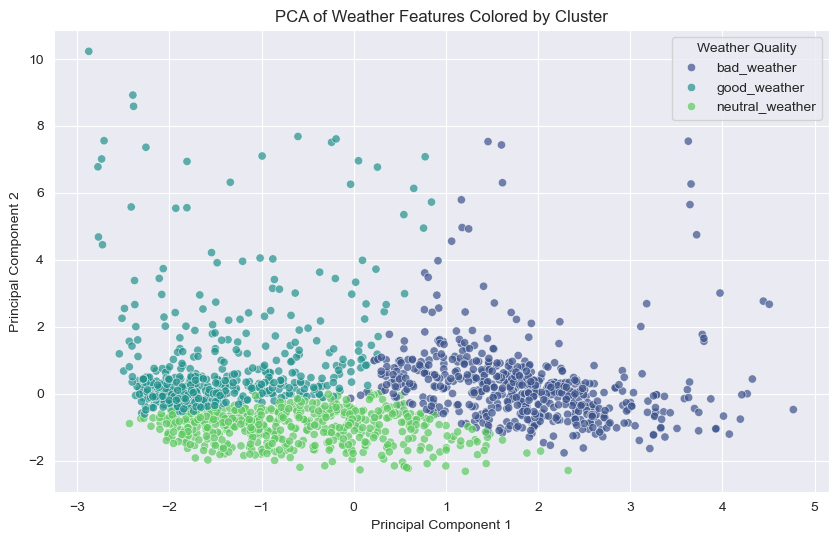

In [48]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, f1_score

"""模型评估函数"""
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=['low_bike_demand', 'high_bike_demand'])
    return accuracy, f1, report
data = pd.read_csv('data/training_data_fall2024.csv')


def process_time_data_scale(data):
    # Transform cyclical time features
    data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
    data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)

    data['day_of_week_sin'] = np.sin(2 * np.pi * data['day_of_week'] / 7)
    data['day_of_week_cos'] = np.cos(2 * np.pi * data['day_of_week'] / 7)

    data['hour_of_day_sin'] = np.sin(2 * np.pi * data['hour_of_day'] / 24)
    data['hour_of_day_cos'] = np.cos(2 * np.pi * data['hour_of_day'] / 24)

    
    # Drop original cyclical features
    data = data.drop(columns=['month', 'day_of_week', 'hour_of_day'], axis=1)

    # Select numerical features to scale (excluding 'holiday' and 'weekday')
    numeric_features = data.drop(['holiday', 'weekday'], axis=1).select_dtypes(include=['int64', 'float64']).columns.tolist()
    
    # Standardize numerical features
    scaler = StandardScaler()
    numeric_data = pd.DataFrame(scaler.fit_transform(data[numeric_features]),
                                columns=numeric_features,
                                index=data.index)

    # Concatenate scaled numerical features with categorical features
    processed_data = pd.concat([data[['holiday', 'weekday']], numeric_data], axis=1)

    return processed_data, scaler


# 对数变换，减少影响
# data = data.drop(columns=['snow',], axis=1)
data['visibility'] = np.log1p(data['visibility'])
data['snowdepth'] = np.log1p(data['snowdepth'])
data['precip'] = np.log1p(data['precip'])
# Apply the processing function
processed_data, scaler = process_time_data_scale(data)

print(processed_data.head())
from sklearn.cluster import KMeans

# Select features for clustering
clustering_features = ['summertime', 'temp', 'dew', 'humidity', 'snowdepth', 'windspeed', 'cloudcover', 'visibility', 'precip', 'snow']

# Initialize K-Means with k=3
kmeans = KMeans(n_clusters=3, random_state=42)

# Fit K-Means on the selected features
kmeans.fit(processed_data[clustering_features])

# Assign cluster labels to the data
processed_data['weather_cluster'] = kmeans.labels_

# Display cluster assignments
print("-----------------------------------")
print(processed_data[['weather_cluster']].head())
print("-----------------------------------\n\n\n")
# Cluster centers
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=clustering_features)
print("Cluster Centers (Original Scale):")
print(cluster_centers)
print("-----------------------------------\n\n\n")
def label_weather_cluster(cluster_label):
    if cluster_label == 1:
        return 'bad_weather'
    elif cluster_label == 0:
        return 'good_weather'
    elif cluster_label == 2:
        return 'neutral_weather'

# Apply labeling
processed_data['weather_quality'] = processed_data['weather_cluster'].apply(label_weather_cluster)

# Display labeled clusters
print(processed_data[['weather_cluster', 'weather_quality']].head())
print("-----------------------------------\n\n\n")
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize PCA
pca = PCA(n_components=2, random_state=42)
principal_components = pca.fit_transform(processed_data[clustering_features])

# Create DataFrame for PCA results
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['weather_cluster'] = processed_data['weather_cluster']
pca_df['weather_quality'] = processed_data['weather_quality']

# Plot clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='weather_quality', data=pca_df, palette='viridis', alpha=0.7)
plt.title('PCA of Weather Features Colored by Cluster')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Weather Quality')
plt.show()

# One-Hot Encode 'weather_quality'
weather_dummies = pd.get_dummies(processed_data['weather_quality'], prefix='weather', drop_first=True)

# Concatenate with the processed data
processed_data = pd.concat([processed_data, weather_dummies], axis=1)

# Define categorical and numerical features
"""移除原本的特征"""
weather_features = ['summertime', 'temp', 'dew', 'humidity', 'snowdepth', 'windspeed', 'cloudcover', 'visibility', 'precip', 'snow']
categorical_features = ['holiday', 'weekday'] + list(weather_dummies.columns)
# 更新 numeric_features，排除天气特征
numeric_features = [col for col in processed_data.columns if col not in [
    'holiday', 'weekday', 'increase_stock', 'weather_cluster', 'weather_quality'
] + list(weather_dummies.columns) + weather_features]

# 将所有布尔类型列转换为整数类型
for col in processed_data.select_dtypes(include=['bool']).columns:
    processed_data[col] = processed_data[col].astype(int)

# Final feature set
X = processed_data[categorical_features + numeric_features].to_numpy().astype(np.float64)
# X = processed_data[categorical_features + numeric_features]
y = data['increase_stock'].map({'low_bike_demand': 0, 'high_bike_demand': 1}).to_numpy().reshape(-1, 1)
# y = data['increase_stock'].map({'low_bike_demand': 0, 'high_bike_demand': 1})

In [44]:
"""你在这里看变量类型"""
processed_data[categorical_features + numeric_features]

,holiday,weekday,weather_good_weather,weather_neutral_weather,month_sin,month_cos,day_of_week_sin,day_of_week_cos,hour_of_day_sin,hour_of_day_cos
0,0,0,0,0,0.678434,1.227255,-1.356549,-0.310979,1.371739,0.367380
1,0,1,0,0,0.678434,1.227255,-0.586476,-1.264846,-1.013450,0.996355
2,0,1,1,0,-1.259495,-0.699517,0.648624,-1.264846,-1.013450,0.996355
3,0,0,0,0,0.678434,1.227255,-1.081713,0.878475,0.363639,1.359495
4,0,1,0,0,1.387764,0.005730,0.031074,1.407831,-1.382440,-0.358899
...,...,...,...,...,...,...,...,...,...,...
1595,0,0,1,0,-0.030897,-1.404765,-1.356549,-0.310979,1.002749,0.996355
1596,0,1,1,0,-0.030897,-1.404765,0.031074,1.407831,-0.718185,-1.210848
1597,0,1,0,0,1.387764,0.005730,0.031074,1.407831,-0.374341,-1.351014
1598,0,0,0,1,1.387764,0.005730,-1.356549,-0.310979,-0.718185,-1.210848


## 随机森林，跑不了就删掉就可以

In [49]:
from scripts.evaluation import evaluate_model
from scripts.hyperparameter_tuning import tune_random_forest_rs
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,
                                                    )

X_train_bal, y_train_bal = X_train, y_train

# Hyperparameter tuning for Random Forest
print("Tuning Random Forest...")
best_rf = tune_random_forest_rs(X_train_bal, y_train_bal)
# Evaluate the tuned Random Forest model
accuracy, f1, report = evaluate_model(best_rf, X_test, y_test)
print(f"Tuned Random Forest Accuracy: {accuracy:.2f}")
print(f"Tuned Random Forest F1 Score: {f1:.2f}")
print("Classification Report:\n", report)
print("Confusion Matrix:\n", confusion_matrix(y_test, best_rf.predict(X_test)))
print(f"\n\n\n\n")

Tuning Random Forest...


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
40 fits failed out of a total of 1500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "C:\ProgramData\anaconda3\Lib\site-package

Tuned Random Forest Accuracy: 0.86
Tuned Random Forest F1 Score: 0.62
Classification Report:
                   precision    recall  f1-score   support

 low_bike_demand       0.94      0.89      0.92       270
high_bike_demand       0.55      0.72      0.62        50

        accuracy                           0.86       320
       macro avg       0.75      0.80      0.77       320
    weighted avg       0.88      0.86      0.87       320

Confusion Matrix:
 [[240  30]
 [ 14  36]]







## QDA and LDA

In [46]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import make_scorer, f1_score, accuracy_score
import numpy as np
from scripts.evaluation import evaluate_model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,
                                                    )
def train_and_evaluate_lda_qda(x, y, k=10):
    # 创建K折交叉验证对象
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    # 初步训练 LDA 模型
    lda = LinearDiscriminantAnalysis()
    f1_lda_scores = cross_val_score(lda, x, y, cv=kf, scoring=make_scorer(f1_score, average='weighted'))
    # f1_lda_scores = cross_val_score(lda, x, y, cv=kf, scoring=make_scorer(accuracy_score, average='weighted'))
    print("===== Initial LDA Cross-Validation Results =====")
    print(f"LDA F1 Scores for each fold: {f1_lda_scores}")
    print(f"Mean LDA F1 Score: {np.mean(f1_lda_scores):.4f}\n")

    # 对LDA模型进行超参数优化（网格搜索）
    param_grid_lda = {
        'solver': ['svd', 'lsqr', 'eigen'],  # 线性判别分析的参数
        'shrinkage': [None, 'auto'],  # 用于LSQR解算器的正则化参数
        'priors': [None, 'uniform'],  # 先验分布
    }

    grid_search_lda = GridSearchCV(lda, param_grid_lda, cv=kf, scoring='f1_weighted')
    # grid_search_lda = GridSearchCV(lda, param_grid_lda, cv=kf, scoring='accuracy_weighted')
    grid_search_lda.fit(x, y)
    accuracy, f1, report = evaluate_model(grid_search_lda, X_test, y_test)
    print("===== Optimized LDA Results =====")
    print(report)
    print(f"Best Parameters: {grid_search_lda.best_params_}")
    print(f"Best Cross-Validation F1 Score: {grid_search_lda.best_score_:.4f}\n")

    # 初步训练 QDA 模型
    qda = QuadraticDiscriminantAnalysis()
    f1_qda_scores = cross_val_score(qda, x, y, cv=kf, scoring=make_scorer(f1_score, average='weighted'))
    # f1_qda_scores = cross_val_score(qda, x, y, cv=kf, scoring=make_scorer(accuracy_score, average='weighted'))
    print("===== Initial QDA Cross-Validation Results =====")
    print(f"QDA F1 Scores for each fold: {f1_qda_scores}")
    print(f"Mean QDA F1 Score: {np.mean(f1_qda_scores):.4f}\n")

    # 对QDA模型进行超参数优化（网格搜索）
    param_grid_qda = {
        'reg_param': [0.0, 0.1, 0.5, 1.0],  # QDA的正则化参数
    }

    grid_search_qda = GridSearchCV(qda, param_grid_qda, cv=kf, scoring='f1_weighted')
    # grid_search_qda = GridSearchCV(qda, param_grid_qda, cv=kf, scoring='accuracy_weighted')
    grid_search_qda.fit(x, y)
    accuracy, f1, report = evaluate_model(grid_search_qda, X_test, y_test)
    print("===== Optimized QDA Results =====")
    print(report)
    print(f"Best Parameters: {grid_search_qda.best_params_}")
    print(f"Best Cross-Validation F1 Score: {grid_search_qda.best_score_:.4f}\n")
y = y.ravel()
train_and_evaluate_lda_qda(x=X, y=y, k=10)

===== Initial LDA Cross-Validation Results =====
LDA F1 Scores for each fold: [0.86990589 0.83498134 0.825      0.87275858 0.85298919 0.89145369
 0.85610649 0.86577274 0.88853161 0.80688812]
Mean LDA F1 Score: 0.8564

===== Optimized LDA Results =====
                  precision    recall  f1-score   support

 low_bike_demand       0.91      0.91      0.91       270
high_bike_demand       0.54      0.54      0.54        50

        accuracy                           0.86       320
       macro avg       0.73      0.73      0.73       320
    weighted avg       0.86      0.86      0.86       320

Best Parameters: {'priors': None, 'shrinkage': None, 'solver': 'lsqr'}
Best Cross-Validation F1 Score: 0.8572

===== Initial QDA Cross-Validation Results =====
QDA F1 Scores for each fold: [0.8619606  0.88383333 0.84778613 0.85715077 0.86965179 0.91928291
 0.87324134 0.8795949  0.89910806 0.87756266]
Mean QDA F1 Score: 0.8769

===== Optimized QDA Results =====
                  precision    rec

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
70 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py", line 621, in fit
    raise NotIm

## Adaboost

In [50]:
from scripts.hyperparameter_tuning import tune_adaboost_rs

print("Tuning Adaboost...")
best_boot = tune_adaboost_rs(X_train_bal, y_train_bal)
accuracy, f1, report = evaluate_model(best_boot, X_test, y_test)
print(f"Tuned Adaboost Accuracy: {accuracy:.2f}")
print(f"Tuned Adaboost F1 Score: {f1:.2f}")
print("Classification Report:\n", report)
print("Confusion Matrix:\n", confusion_matrix(y_test, best_boot.predict(X_test)))
print(f"\n\n\n\n")

Tuning Adaboost...
Tuned Adaboost Accuracy: 0.87
Tuned Adaboost F1 Score: 0.56
Classification Report:
                   precision    recall  f1-score   support

 low_bike_demand       0.92      0.93      0.92       270
high_bike_demand       0.59      0.54      0.56        50

        accuracy                           0.87       320
       macro avg       0.75      0.73      0.74       320
    weighted avg       0.86      0.87      0.87       320

Confusion Matrix:
 [[251  19]
 [ 23  27]]





